<a href="https://colab.research.google.com/github/ChengyangHuang/Divergence-Estimation/blob/main/Nonparametric_Divergence_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Divergence Estimator

In [1]:
import numpy as np
import math

from scipy.spatial import distance_matrix
from scipy.special import gamma

from sklearn.neighbors import KernelDensity
from sklearn.neighbors import NearestNeighbors

import cvxpy as cp 

from tqdm.notebook import  tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


class divergence_estimator():
    def __init__(self, rvs_1, rvs_2):
        assert rvs_1.shape[1] == rvs_2.shape[1]
        self.rvs_1 = rvs_1
        self.rvs_2 = rvs_2
        self.N = rvs_1.shape[0]
        self.M = rvs_2.shape[0]
        self.d = rvs_1.shape[1]
        

    def kl_intg(self):
        pass

    def renyi_alpha_intg(self):
        pass


class endive_kde(divergence_estimator):
    """
        Ensemble estimation of information divergence
        https://www.mdpi.com/1099-4300/20/8/560
    """
    def __init__(self, rvs_1, rvs_2, kmin=1, kmax=50, L=60, eta=1, delta=1):
        super().__init__(rvs_1, rvs_2)
        rvs_all = np.vstack((rvs_1, rvs_2))
        knn = NearestNeighbors(n_neighbors=kmax).fit(rvs_all)
        neigh_dist = knn.kneighbors()[0]
        lmin = neigh_dist[:, kmin].max() / (self.N ** (-1 / (self.d + delta)))
        lmax = neigh_dist[:, -1].max() / (self.N ** (-1 / (self.d + delta)))
        L_set = np.linspace(lmin, lmax, L)

        lam = math.ceil(self.d / delta) + 1
        s = math.ceil((self.d + delta) / 2) 
        eps = cp.Variable()
        w = cp.Variable(L)
        objective = cp.Minimize(eps)
        constraints = [np.ones((1, L)) @ w == 1,
                       cp.norm(w, 2) ** 2 <= eta * eps]

        for q in range(math.ceil(lam / 2) + 1):
            for j in range(s+1):
                if (j + q) > 0 and (j + q) < ((self.d + 1) / 2):
                    constraints.append(self.N ** (-(j+q)/(self.d+1) + 1/2) * (w @ (L_set**(j - self.d * q)) ) <= eps)

        problem = cp.Problem(objective, constraints)
        problem.solve()

        self.delta = delta
        self.L_set = L_set
        self.weight = w.value

    def renyi_alpha_intg(self, alpha=0.5, kernel='tophat'):
        renyi_KDE = []
        for l in self.L_set:
            kde_1 = KernelDensity(kernel=kernel, bandwidth=(l*self.N**(-1/(self.d+self.delta)))).fit(self.rvs_1)
            kde_2 = KernelDensity(kernel=kernel, bandwidth=(l*self.N**(-1/(self.d+self.delta)))).fit(self.rvs_2)
            f1_pdf = np.exp(kde_1.score_samples(self.rvs_1))
            f2_pdf = np.exp(kde_2.score_samples(self.rvs_1))
            renyi_KDE.append(np.dot((f1_pdf ** alpha), (f2_pdf ** (1-alpha))) / self.N)

        renyi_KDE = np.array(renyi_KDE)
        renyi_EnDive = np.dot(self.weight, renyi_KDE)
        return renyi_EnDive, renyi_KDE


class knn_estimator(divergence_estimator):
    def __init__(self, rvs_1, rvs_2, n_neighbors):
        super().__init__(rvs_1, rvs_2)
        self.k = n_neighbors

    def kl_intg(self):
        pass

    def renyi_alpha_intg(self, alpha=0.5, fast=True):
        """
            Nonparametric Divergence Estimation with Applications to Machine Learning on Distributions
            https://arxiv.org/abs/1202.3758
        """
        B = gamma(self.k)**2 / (gamma(self.k - alpha + 1) * gamma(self.k + alpha - 1))
        if fast:
            self.knn_1 = NearestNeighbors(n_neighbors=self.k, algorithm='auto').fit(self.rvs_1)
            self.knn_2 = NearestNeighbors(n_neighbors=self.k, algorithm='auto').fit(self.rvs_2)
            rho = self.knn_1.kneighbors(self.rvs_1)[0][:, -1]
            nu = self.knn_2.kneighbors(self.rvs_1)[0][:, -1]
        else:
            dist_mat_11 = distance_matrix(self.rvs_1, self.rvs_1)
            dist_mat_12 = distance_matrix(self.rvs_1, self.rvs_2)
            dist_mat_11.sort(axis=1)
            dist_mat_12.sort(axis=1)
            rho = dist_mat_11[:, self.k]
            nu = dist_mat_12[:, self.k-1]

        renyi_alpha = B / self.N * np.sum(np.divide((self.N-1)*rho**self.d, self.M*nu**self.d)**(1-alpha))
        return renyi_alpha

# Experiments

## Convergence Rates Validation: Rényi-α Divergence

### Truncated Gaussian

In [2]:
from scipy.stats import truncnorm
import scipy.integrate as integrate    


def renyi_alpha_div_integral(alpha, p, q, a, b, N=None):
    if N == None:
        return integrate.quad(lambda x: (p(x) ** alpha) * (q(x) ** (1 - alpha)), a, b)
    else:
        x = np.linspace(a, b, N)
        return np.dot(p(x) ** alpha, q(x) ** (1 - alpha)) / N


def kl_div_integral(p, q, a, b, N=None):
    if N == None:
        return integrate.quad(lambda x: p(x) * math.log(p(x)/q(x)), a, b)
    else:
       x = np.linspace(a, b, N)
       return np.dot(p(x), np.log(p(x)/q(x))) / N


def truncated_Gaussian_experiment(d=5, N=2000, 
                                  mu_1=0.7, sigma_1=np.sqrt(0.4),
                                  mu_2=0.3, sigma_2=np.sqrt(0.4),
                                  a=0, b=1):
    
    a_1, b_1 = (a - mu_1) / sigma_1, (b - mu_1) / sigma_1
    a_2, b_2 = (a - mu_2) / sigma_2, (b - mu_2) / sigma_2

    f_1 = truncnorm(a_1, b_1, mu_1, sigma_1)
    f_2 = truncnorm(a_2, b_2, mu_2, sigma_2)
    rvs_1 = f_1.rvs(size=(N, d))
    rvs_2 = f_2.rvs(size=(N, d))

    # # Plot PDF
    # x = np.linspace(a, b, 1000)
    # pdf_1 = f_1.pdf(x)
    # pdf_2 = f_2.pdf(x)
    # fig, ax = plt.subplots(1, 1)
    # ax.plot(x, f_1.pdf(x), label='f1')
    # ax.plot(x, f_2.pdf(x), label='f2')
    # ax.set_ylabel("pdf")
    # ax.legend()

    # Renyi-alpha
    renyi_alpha_dict = {}
    alpha = 0.5 
    renyi_alpha_dict["GT_intg"] = renyi_alpha_div_integral(alpha, f_1.pdf, f_2. pdf, a, b)[0]**d
    renyi_alpha_dict["GT_est"] = renyi_alpha_div_integral(alpha, f_1.pdf, f_2. pdf, a, b, N)**d
    
    knn_divest = knn_estimator(rvs_1, rvs_2, 20)
    renyi_alpha_dict["knn_fast"] = knn_divest.renyi_alpha_intg(alpha, fast=True)
    renyi_alpha_dict["knn_brute"] = knn_divest.renyi_alpha_intg(alpha, fast=False)
    
    endive_divest = endive_kde(rvs_1, rvs_2)
    renyi_endive, renyi_kde = endive_divest.renyi_alpha_intg(alpha)
    renyi_alpha_dict["endive_kde"] = renyi_endive
    renyi_alpha_dict["kde_best"] = renyi_kde[((renyi_kde - renyi_alpha_dict["GT_intg"])**2).argmin()]

    # KL
    kl_gt1 = kl_div_integral(f_1.pdf, f_2. pdf, a, b)[0]
    kl_gt2 = kl_div_integral(f_1.pdf, f_2. pdf, a, b, 1000)

    return renyi_alpha_dict


truncated_Gaussian_experiment()

{'GT_est': 0.9528751587084865,
 'GT_intg': 0.9533316996544592,
 'endive_kde': 0.9068481886457284,
 'kde_best': 0.6771906672446735,
 'knn_brute': 0.9593546818267554,
 'knn_fast': 0.932249139592021}

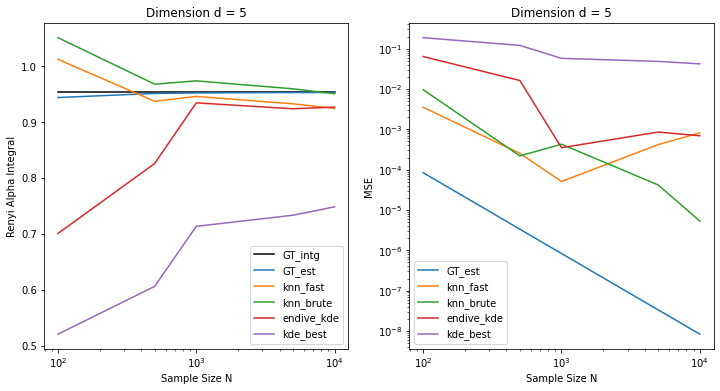

In [3]:
def convergence_validation():
    d_list = [5]
    N_list = [100, 500, 1000, 5000, 10000]

    for d in d_list:
        result_dict = {}
        for N in tqdm(N_list):
            renyi_alpha_dict = truncated_Gaussian_experiment(d, N)
            for key, value in renyi_alpha_dict.items():
                if key in result_dict.keys():
                    result_dict[key].append(renyi_alpha_dict[key])
                else:
                    result_dict[key] = [renyi_alpha_dict[key]]

        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        for key, value in result_dict.items():
            if key != 'GT_intg':
                gt = np.array(result_dict['GT_intg'])
                value = np.array(value)
                ax[0].semilogx(N_list, value, label=key)
                ax[1].loglog(N_list, (gt - value)**2, label=key)
            else:
                ax[0].semilogx(N_list, value, label=key, color="black")
        ax[0].legend()
        ax[0].set_xlabel("Sample Size N")
        ax[0].set_ylabel("Renyi Alpha Integral")
        ax[0].set_title(f"Dimension d = {d}")

        ax[1].legend()
        ax[1].set_xlabel("Sample Size N")
        ax[1].set_ylabel("MSE")
        ax[1].set_title(f"Dimension d = {d}")
        plt.show()


convergence_validation()    